In [134]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import io
import itertools
import matplotlib.pyplot as plt

In [4]:
BUFFER_SIZE=10000
BATCH_SIZE=128
NUM_EPOCHS=20

In [5]:
mnist_dataset,mnist_info=tfds.load(name='mnist',with_info=True,as_supervised=True)

In [6]:
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']
mnist_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    image = tf.expand_dims(image, axis=-1)  # Add channel dimension (28, 28, 1)
    return image, label

In [16]:
train_and_validation_data = mnist_train.map(scale).shuffle(BUFFER_SIZE)
test_data = mnist_test.map(scale)

In [18]:
num_validation_samples = int(0.1 * mnist_info.splits['train'].num_examples)
num_test_samples = mnist_info.splits['test'].num_examples

In [20]:
num_test_samples=mnist_info.splits['test'].num_examples
num_test_samples=tf.cast(num_test_samples,tf.int64)

In [22]:
train_and_validation_data=train_and_validation_data.shuffle(BUFFER_SIZE)

In [24]:
train_data=train_and_validation_data.skip(num_validation_samples)
validation_data=train_and_validation_data.take(num_validation_samples)

In [136]:
train_data=train_data.batch(BATCH_SIZE)
validation_data=validation_data.batch(num_validation_samples)
test_data=test_data.batch(num_test_samples)

In [138]:
for images,labels in validation_data:
    images_val=images.numpy()
    labels_val=labels.numpy()

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])

/home/bizmotion/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.summary(line_length=75)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                   ┃ Output Shape            ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                │ (None, 24, 24, 50)      │        1,300 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)   │ (None, 12, 12, 50)      │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)              │ (None, 10, 10, 50)      │       22,550 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ max_pooling2d_1 (MaxPooling2D) │ (None, 5, 5, 50)        │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ flatten (Flatten)              │ (None, 1250)            │            0 │
├────────────────────────────────┼─────────────────────────┼──────────────┤
│ dense (Dense)                  │ (None, 10)              │       12,510 │
└────────────────────────────────┴─────────────────────────┴──────────────┘

 Total params: 36,360 (142.03 KB)

 Trainable params: 36,360 (142.03 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [35]:
model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])

In [140]:
log_dir="logs\\fit\\"+"run-1"

In [146]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nea rest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [148]:
# Define a file writer variable for logging purposes
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(images_val)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
    
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [150]:
cm_callback=tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
dashboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,profile_batch=0)

In [144]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [156]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

In [154]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [162]:
model.fit(
    train_data,
    epochs=NUM_EPOCHS,
    callbacks=[tensorborad_callback,early_stopping],
    validation_data=validation_data,
    verbose=2
)

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=True
  • mask=None

In [112]:
test_loss,test_accuracy = model.evaluate(test_data)

2024-09-19 20:51:15.607472: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1152000000 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9916 - loss: 0.0327


In [114]:
print('Test loss: {0: .4f}. Test accuracy: {1: .2f}%'.format(test_loss,test_accuracy*100.))

Test loss:  0.0327. Test accuracy:  99.16%


In [116]:
import matplotlib.pyplot as plt
import numpy as np

In [118]:
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

2024-09-19 20:51:28.056982: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


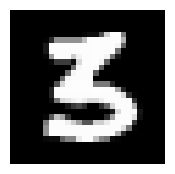

Label: 3


In [120]:
i = 9


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<BarContainer object of 10 artists>

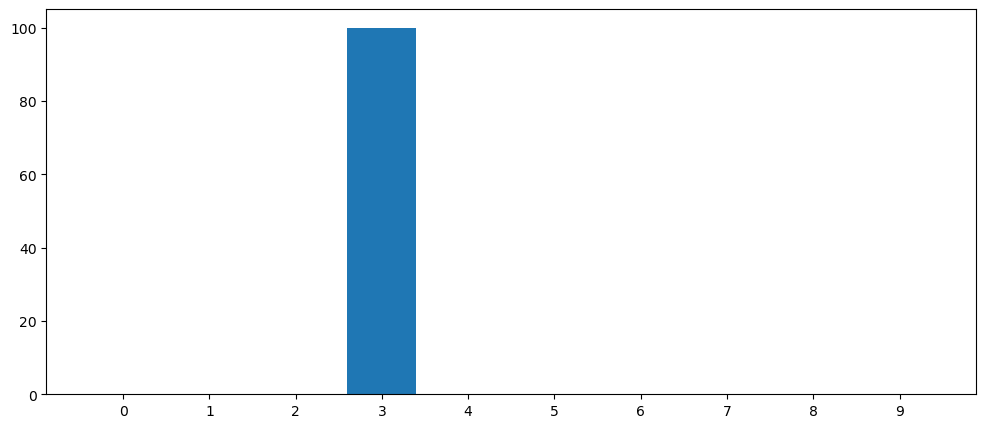

In [122]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])

In [130]:
%load_ext tensorboard
%tensorboard --logdir logs/fit


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12129), started 0:21:46 ago. (Use '!kill 12129' to kill it.)

In [132]:
%reload_ext tensorboard